Studying the local 3D scale of neurons in developing Xenopus laevis tadpoles under effect of down syndrome cell adhesion molecule (DSCAM).


# Packages importation and general configuration

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.stats.multicomp import multipletests

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits import mplot3d

In [2]:
from genepy3d.io import swc
from genepy3d.obj import curves, trees, points
from genepy3d.util import geo, plot as mypl

In [3]:
%matplotlib notebook

# Reading neuronal traces from SWC files

In [4]:
# initialize swc importer
filepath = "../data/dscam/swc/"
f = swc.SWC(filepath,recursive=True)

In [5]:
print("nb. of imported neurons:",len(f.get_neuron_id()))

nb. of imported neurons: 412


# Setting scale range

The maximal scale (rmax) is defined based on the length of the longest branch in dataset (i.e. rmax = 1/3 * 180 microns).

In [6]:
rmin, rmax = 1, 61
r_lst = np.arange(rmin,rmax,2)
print("list of scales:",r_lst)

list of scales: [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47
 49 51 53 55 57 59]


# Building analysed dataframe

In [7]:
# columns in dataframe
# - neuidlst: neuron ID
# - type_flag: 
#   - DownregTectal: Downregulation of DSCAM of tectal neuron
#   - OverexprTectal: Overexpression of DSCAM of tectal neuron
#   - DownregAxon: Downregulation of DSCAM of retina ganglion axon
# - exp_flag: conditons "CONTROL" or "DSCAM"
# - day_flag: days "D1", "D2", "D3", "D4"

neuidlst, type_flag, exp_flag, day_flag = [], [], [], []

In [8]:
# Downregulation tectal neurons
group = "Downreg_Tectal_Neurons_MO-CTRL-"
days = ["D1","D2","D3"]
for day in days:
    pattern = group+day
    groupids = np.array(f.neuronidlst)[[pattern in file for file in f.filelst]]
    exp_flag = exp_flag + ["CONTROL" for _ in groupids]
    day_flag = day_flag + [day for _ in groupids]
    type_flag = type_flag + ["DownregTectal" for _ in groupids]
    neuidlst = neuidlst + list(groupids)
    
group = "Downreg_Tectal_Neurons_MO-DSCAM-"
days = ["D1","D2","D3"]
for day in days:
    pattern = group+day
    groupids = np.array(f.neuronidlst)[[pattern in file for file in f.filelst]]
    exp_flag = exp_flag + ["DSCAM" for _ in groupids]
    day_flag = day_flag + [day for _ in groupids]
    type_flag = type_flag + ["DownregTectal" for _ in groupids]
    neuidlst = neuidlst + list(groupids)

In [9]:
# Overexpression tectal neurons
group = "Overexpr_Tectal_Neurons-Ctrl-"
days = ["D2","D3","D4"]
for day in days:
    pattern = group+day
    groupids = np.array(f.neuronidlst)[[pattern in file for file in f.filelst]]
    exp_flag = exp_flag + ["CONTROL" for _ in groupids]
    day_flag = day_flag + [day for _ in groupids]
    type_flag = type_flag + ["OverexprTectal" for _ in groupids]
    neuidlst = neuidlst + list(groupids)
    
group = "Overexpr_Tectal_Neurons-xDSCAM-"
days = ["D2","D3","D4"]
for day in days:
    pattern = group+day
    groupids = np.array(f.neuronidlst)[[pattern in file for file in f.filelst]]
    exp_flag = exp_flag + ["DSCAM" for _ in groupids]
    day_flag = day_flag + [day for _ in groupids]
    type_flag = type_flag + ["OverexprTectal" for _ in groupids]
    neuidlst = neuidlst + list(groupids)

In [10]:
# Downregulation RGC axon
group = "Downreg_RGCs_AXON_MO-CTRL-"
days = ["D1","D2","D3"]
for day in days:
    pattern = group+day
    groupids = np.array(f.neuronidlst)[[pattern in file for file in f.filelst]]
    exp_flag = exp_flag + ["CONTROL" for _ in groupids]
    day_flag = day_flag + [day for _ in groupids]
    type_flag = type_flag + ["DownregAxon" for _ in groupids]
    neuidlst = neuidlst + list(groupids)
    
group = "Downreg_RGCs_AXONS_MO-DSCAM-"
days = ["D1","D2","D3"]
for day in days:
    pattern = group+day
    groupids = np.array(f.neuronidlst)[[pattern in file for file in f.filelst]]
    exp_flag = exp_flag + ["DSCAM" for _ in groupids]
    day_flag = day_flag + [day for _ in groupids]
    type_flag = type_flag + ["DownregAxon" for _ in groupids]
    neuidlst = neuidlst + list(groupids)

In [12]:
# making dataframe
nbbranching_lst, arborlength_lst, localscale_lst = [], [], []
longestlength_lst, longestwigg_lst, longestscale_lst = [], [], []
for i in range(len(neuidlst)):
    
    data = tuple(np.load("../data/dscam/result/neuron_{}.npy".format(neuidlst[i]),allow_pickle=True))
    nb_branching, arbor_length, ls_mean, spine_ls_mean, spine_wiggliness, new_neuron = data
    
    nbbranching_lst.append(nb_branching)
    arborlength_lst.append(arbor_length)
    longestlength_lst.append(new_neuron.compute_length(new_neuron.compute_spine()))
    localscale_lst.append(ls_mean)
    longestscale_lst.append(spine_ls_mean)
    longestwigg_lst.append(spine_wiggliness)
    
df = pd.DataFrame({"Id":range(len(neuidlst)),"Type":type_flag,"Experiment":exp_flag,"Day":day_flag,
                   "Number of branching":nbbranching_lst,"Length":arborlength_lst,"Longest branch length":longestlength_lst,
                   "Mean 3D scale":localscale_lst,"Longest branch mean 3D scale":longestscale_lst,
                   "Longest branch tortuosity":longestwigg_lst})
df.set_index("Id",inplace=True)
df.head()

Type Experiment Day  Number of branching      Length  \
Id                                                                  
0   DownregTectal    CONTROL  D1                   13  394.409439   
1   DownregTectal    CONTROL  D1                    5  101.255850   
2   DownregTectal    CONTROL  D1                   11  445.555491   
3   DownregTectal    CONTROL  D1                   21  706.426593   
4   DownregTectal    CONTROL  D1                   14  703.185730   

    Longest branch length  Mean 3D scale  Longest branch mean 3D scale  \
Id                                                                       
0               96.733448      43.172917                     42.035533   
1               45.168989      52.551020                     51.109589   
2              111.140944      40.298701                     35.994175   
3              127.886067      41.811034                     37.615172   
4              141.709826      39.238741                     36.692308   

    Longest branch tortuosity  
Id                             
0                    1.328739  
1                    1.216607  
2                    2.259089  
3                    1.379558  
4                    1.206431

# Overexpression tectal neurons

In [13]:
# extract a sub dataframe for only overexpression case
subdf = df[df["Type"]=="OverexprTectal"].copy()

## Distribution

<IPython.core.display.Javascript object>


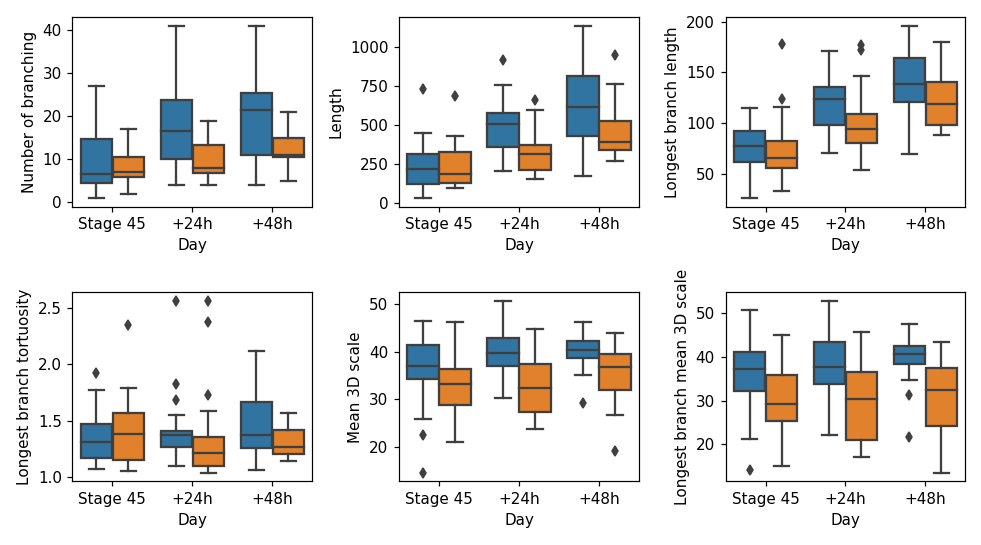

In [17]:
fig = plt.figure(figsize=(9,5))

ax = fig.add_subplot(231)
sns.boxplot(x="Day",y="Number of branching",data=subdf,hue="Experiment");
ax.set_xticklabels(["Stage 45", "+24h", "+48h"])
ax.get_legend().remove()

ax = fig.add_subplot(232)
sns.boxplot(x="Day",y="Length",data=subdf,hue="Experiment");
ax.set_xticklabels(["Stage 45", "+24h", "+48h"])
ax.get_legend().remove()

ax = fig.add_subplot(233)
sns.boxplot(x="Day",y="Longest branch length",data=subdf,hue="Experiment");
ax.set_xticklabels(["Stage 45", "+24h", "+48h"])
ax.get_legend().remove()

ax = fig.add_subplot(234)
pl = sns.boxplot(x="Day",y="Longest branch tortuosity",data=subdf,hue="Experiment");
ax.set_xticklabels(["Stage 45", "+24h", "+48h"])
ax.get_legend().remove()

ax = fig.add_subplot(235)
sns.boxplot(x="Day",y="Mean 3D scale",data=subdf,hue="Experiment");
ax.set_xticklabels(["Stage 45", "+24h", "+48h"])
ax.get_legend().remove()

ax = fig.add_subplot(236)
sns.boxplot(x="Day",y="Longest branch mean 3D scale",data=subdf,hue="Experiment");
ax.set_xticklabels(["Stage 45", "+24h", "+48h"])
ax.get_legend().remove()

plt.tight_layout();

## Statistical tests

### Making test dataframe

In [18]:
# setting feature to be tested, can be:
# - Mean 3D scale
# - Longest branch mean 3D scale
# - Longest branch tortuosity
# - Longest branch length
test_feature = "Mean 3D scale"

value, day, treatment = [], [], []
for iday in ["D2","D3","D4"]:
    tmpdf = subdf[subdf["Day"]==iday]
    value = value + tmpdf[test_feature].tolist()
    day = day + [iday for _ in range(len(tmpdf))]
    treatment = treatment + tmpdf["Experiment"].tolist()
ssubdf = pd.DataFrame({"day":day,"treatment":treatment,"value":value})

ssubdf["day-treatment"] = ssubdf["day"]+"-"+ssubdf["treatment"]

# can use one of following lines to transform data to meet normal condition when using ttest
# ssubdf["value"] = np.log(ssubdf["value"])
# ssubdf["value"] = np.sqrt(ssubdf["value"])
# ssubdf["value"] = np.sqrt(max(ssubdf["value"]+1)-ssubdf["value"])

ssubdf.head()

day treatment      value day-treatment
0  D2   CONTROL  46.369295    D2-CONTROL
1  D2   CONTROL  14.626667    D2-CONTROL
2  D2   CONTROL  34.280000    D2-CONTROL
3  D2   CONTROL  28.476764    D2-CONTROL
4  D2   CONTROL  37.224138    D2-CONTROL

### Ttest with holm-sidak

In [19]:
pval_lst = []
# for iday in ["D1","D2","D3","D1"]:
for iday in ["D2","D3","D4"]:
    var1 = ssubdf[(ssubdf["day"]==iday)&(ssubdf["treatment"]=="CONTROL")]["value"]
    var2 = ssubdf[(ssubdf["day"]==iday)&(ssubdf["treatment"]=="DSCAM")]["value"]
    _, pval = ttest_ind(var1,var2,equal_var=False)
    pval_lst.append(pval)
_, pval_lst_corr, _, _ = multipletests(pval_lst,method="holm-sidak")

print("p values:",pval_lst)
print("p values corrected:",pval_lst_corr)

p values: [0.15043346807139582, 0.0005669226244078875, 0.005842818837544899]
p values corrected: [0.15043347 0.0016998  0.0116515 ]


## Illustrating some examples

### Control examples

<IPython.core.display.Javascript object>


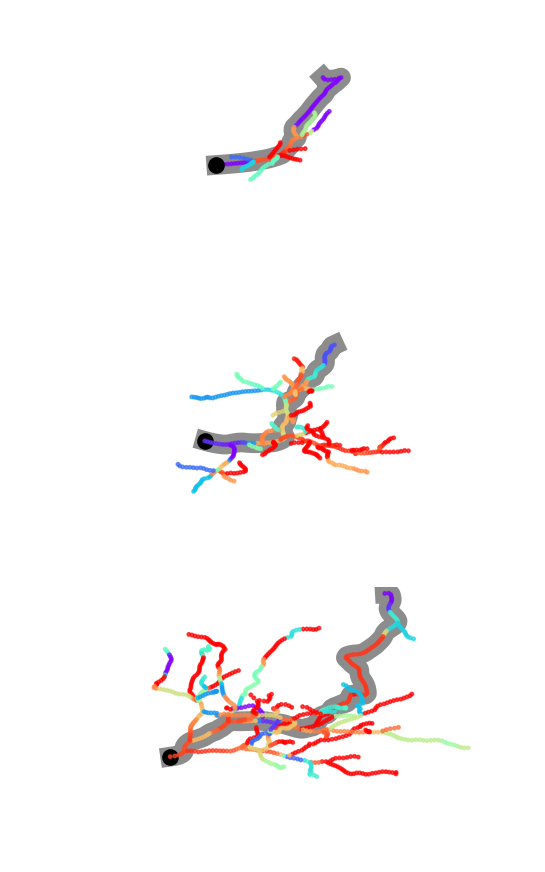

/home/phantom/Projects/Git/Gitlab/genepy3d/src/genepy3d/util/plot.py:22: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  pl = ax.plot(x,y,z,**line_args)


In [21]:
ctrl_example = [207,226,249]
# camera_init = [[-25,44],[-60,116],[-130,80]]
camera_init = [[-155,90],[-165,65],[-150,-80]]
ax_dist = [13,9,8]

fig, axes = plt.subplots(3, 1, subplot_kw=dict(projection='3d'),figsize=(5,8))
for i in range(len(ctrl_example)):
    
    ax = axes[i]
    
    data = tuple(np.load("../data/dscam/result/neuron_{}.npy".format(neuidlst[ctrl_example[i]]),allow_pickle=True))
    nb_branching, arbor_length, ls_mean, spine_ls_mean, spine_wiggliness, newneuron = data
    lsdf = pd.read_csv("../data/dscam/result/neuron_{}.csv".format(neuidlst[ctrl_example[i]]))
    lsdf.set_index("nodeid",inplace=True)
    meandf = lsdf.groupby("nodeid")["local_scale"].mean()
    
    newneuron.plot(ax,spine_only=True,show_leaves=False,line_args={"color":"gray","lw":13,"alpha":0.9})

    coors = newneuron.get_coordinates(meandf.index.values).values
    pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],s=5,c=meandf.values.flatten(),cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.7)
    
    rootc = newneuron.get_coordinates(newneuron.get_root()).values.flatten()
    ax.scatter(rootc[0],rootc[1],rootc[2],color="k",s=100)

    param = mypl.fix_equal_axis(coors)
    ax.set_xlim(param['xmin'],param['xmax'])
    ax.set_ylim(param['ymin'],param['ymax'])
    ax.set_zlim(param['zmin'],param['zmax']);
    ax.view_init(azim=camera_init[i][0],elev=camera_init[i][1]);
    if ax_dist[i]!=-1:
        ax.dist = ax_dist[i]

plt.subplots_adjust(wspace=0, hspace=0);
plt.tight_layout();

for ax in axes.flatten():
    ax.axis("off");

### DSCAM examples

<IPython.core.display.Javascript object>


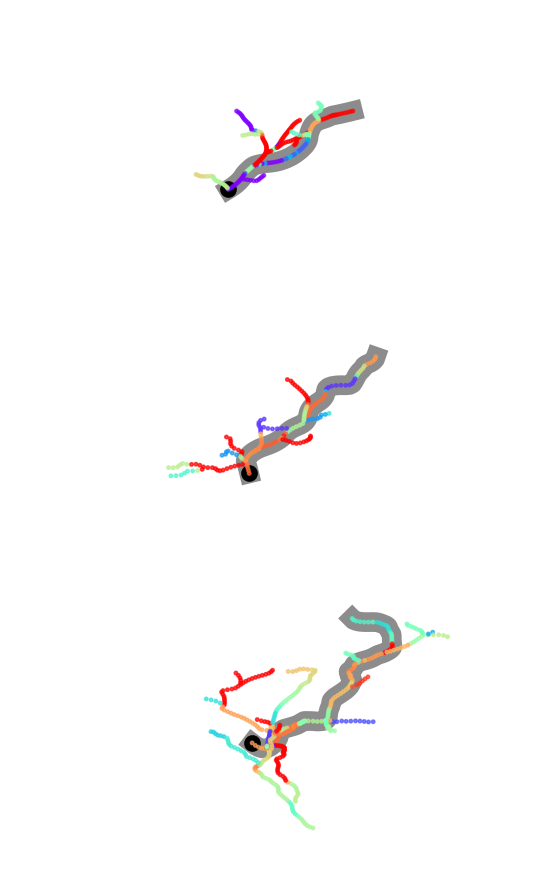

In [22]:
dscam_example = [254,287,308]
# camera_init = [[-20,80],[-25,-75],[-170,50]]
camera_init = [[-130,80],[-23,80],[-175,-134]]
ax_dist = [14,10,7]

fig, axes = plt.subplots(3, 1, subplot_kw=dict(projection='3d'),figsize=(5,8))
for i in range(len(dscam_example)):
    
    ax = axes[i]
    
    data = tuple(np.load("../data/dscam/result/neuron_{}.npy".format(neuidlst[dscam_example[i]]),allow_pickle=True))
    nb_branching, arbor_length, ls_mean, spine_ls_mean, spine_wiggliness, newneuron = data
    lsdf = pd.read_csv("../data/dscam/result/neuron_{}.csv".format(neuidlst[dscam_example[i]]))
    lsdf.set_index("nodeid",inplace=True)
    meandf = lsdf.groupby("nodeid")["local_scale"].mean()
    
    newneuron.plot(ax,spine_only=True,show_leaves=False,line_args={"color":"gray","lw":13,"alpha":0.9})

    coors = newneuron.get_coordinates(meandf.index.values).values
    pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],s=5,c=meandf.values.flatten(),cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.7)
    
    rootc = newneuron.get_coordinates(newneuron.get_root()).values.flatten()
    ax.scatter(rootc[0],rootc[1],rootc[2],color="k",s=100)

    param = mypl.fix_equal_axis(coors)
    ax.set_xlim(param['xmin'],param['xmax'])
    ax.set_ylim(param['ymin'],param['ymax'])
    ax.set_zlim(param['zmin'],param['zmax']);
    ax.view_init(azim=camera_init[i][0],elev=camera_init[i][1]);
    if ax_dist[i]!=-1:
        ax.dist = ax_dist[i]

plt.subplots_adjust(wspace=0, hspace=0);
plt.tight_layout();

for ax in axes.flatten():
    ax.axis("off");

### Custom scale colorbar

<IPython.core.display.Javascript object>


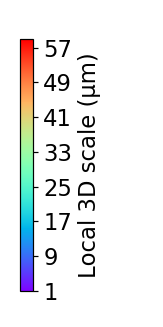

In [23]:
fig, ax = plt.subplots(figsize=(1.5, 3))
fig.subplots_adjust(right=0.2)

norm = mpl.colors.Normalize(vmin=r_lst[0], vmax=r_lst[-1])
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('rainbow'),norm=norm,orientation='vertical')
cb1.set_ticks(r_lst[0::4])
cb1.set_label('Local 3D scale (µm)',fontsize=15);
cb1.ax.tick_params(labelsize=15)

## Correlation

<IPython.core.display.Javascript object>


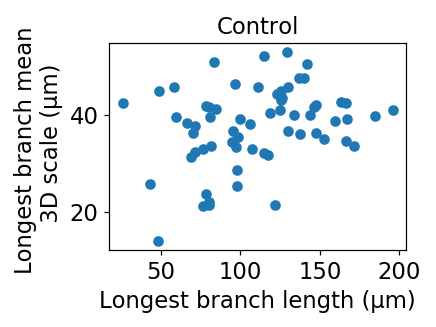

In [24]:
fz = 15
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
tmpdf = subdf[subdf["Experiment"]=="CONTROL"]
ax.scatter(tmpdf["Longest branch length"],tmpdf["Longest branch mean 3D scale"]);
# sns.lineplot(tmpdf["Longest branch length"],tmpdf["Longest branch mean 3D scale"])
ax.set_xlabel("Longest branch length (µm)",fontsize=fz);
ax.set_ylabel("Longest branch mean \n 3D scale (µm)",fontsize=fz);
ax.set_title("Control",fontsize=fz)
ax.tick_params(labelsize=fz)
plt.tight_layout();

In [25]:
tmpdf = subdf[subdf["Experiment"]=="CONTROL"]
pearson, pval = stats.spearmanr(tmpdf["Longest branch length"].values,tmpdf["Longest branch mean 3D scale"].values)
print("pearson coef = {}, pvalue = {}".format(pearson,pval))

pearson coef = 0.29139194139194136, pvalue = 0.019484175249780706


<IPython.core.display.Javascript object>


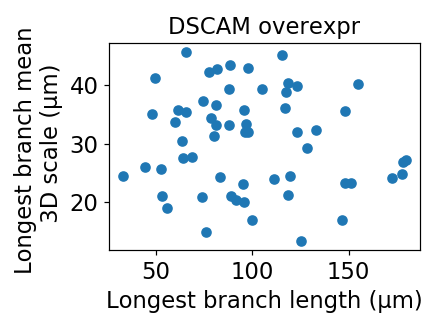

In [26]:
fz = 15
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
tmpdf = subdf[subdf["Experiment"]=="DSCAM"]
ax.scatter(tmpdf["Longest branch length"],tmpdf["Longest branch mean 3D scale"]);
# sns.lineplot(tmpdf["Longest branch length"],tmpdf["Longest branch mean 3D scale"])
ax.set_xlabel("Longest branch length (µm)",fontsize=fz);
ax.set_ylabel("Longest branch mean \n 3D scale (µm)",fontsize=fz);
ax.set_title("DSCAM overexpr",fontsize=fz)
ax.tick_params(labelsize=fz)
plt.tight_layout();

In [27]:
tmpdf = subdf[subdf["Experiment"]=="DSCAM"]
pearson, pval = stats.spearmanr(tmpdf["Longest branch length"].values,tmpdf["Longest branch mean 3D scale"].values)
print("pearson coef = {}, pvalue = {}".format(pearson,pval))

pearson coef = -0.08088836937463473, pvalue = 0.5425105915846844


# Downregulation tectal neurons

In [28]:
subdf = df[df["Type"]=="DownregTectal"].copy()

## Distribution

<IPython.core.display.Javascript object>


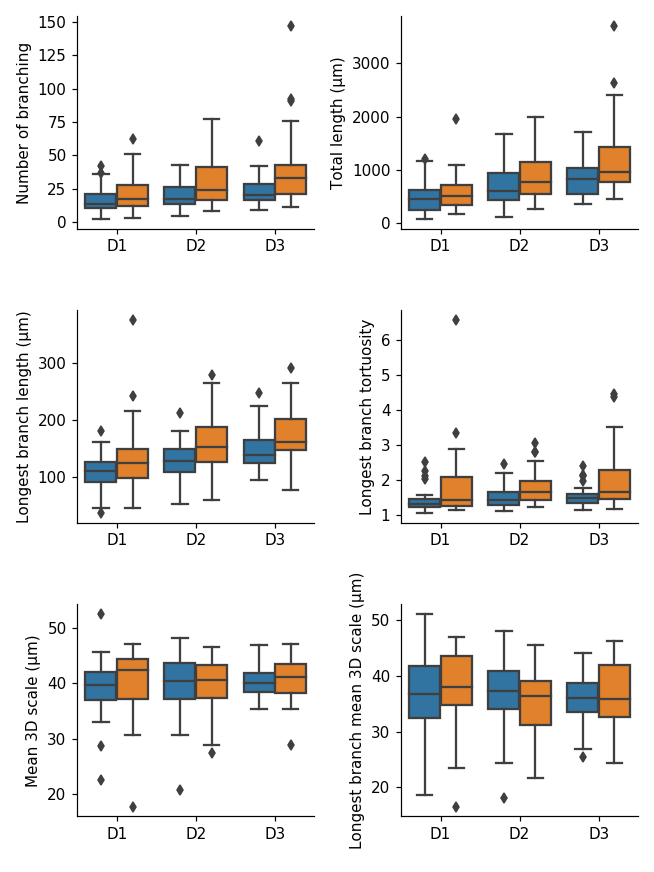

In [29]:
fig = plt.figure(figsize=(6,8))

ax = fig.add_subplot(321)
sns.boxplot(x="Day",y="Number of branching",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("");

ax = fig.add_subplot(322)
sns.boxplot(x="Day",y="Length",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Total length (µm)");
ax.set_xlabel("");

ax = fig.add_subplot(324)
pl = sns.boxplot(x="Day",y="Longest branch tortuosity",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("");

ax = fig.add_subplot(323)
sns.boxplot(x="Day",y="Longest branch length",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Longest branch length (µm)");
ax.set_xlabel("");

ax = fig.add_subplot(325)
sns.boxplot(x="Day",y="Mean 3D scale",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Mean 3D scale (µm)");
ax.set_xlabel("");

ax = fig.add_subplot(326)
sns.boxplot(x="Day",y="Longest branch mean 3D scale",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Longest branch mean 3D scale (µm)");
ax.set_xlabel("");

plt.tight_layout();

## Statistical tests

In [30]:
test_feature = "Mean 3D scale"

value, day, treatment = [], [], []
for iday in ["D1","D2","D3"]:
    tmpdf = subdf[subdf["Day"]==iday]
    value = value + tmpdf[test_feature].tolist()
    day = day + [iday for _ in range(len(tmpdf))]
    treatment = treatment + tmpdf["Experiment"].tolist()
ssubdf = pd.DataFrame({"day":day,"treatment":treatment,"value":value})

ssubdf["day-treatment"] = ssubdf["day"]+"-"+ssubdf["treatment"]

# ssubdf["value"] = np.log(ssubdf["value"])
# ssubdf["value"] = np.sqrt(ssubdf["value"])
# ssubdf["value"] = np.sqrt(max(ssubdf["value"]+1)-ssubdf["value"])

ssubdf.head()

day treatment      value day-treatment
0  D1   CONTROL  43.172917    D1-CONTROL
1  D1   CONTROL  52.551020    D1-CONTROL
2  D1   CONTROL  40.298701    D1-CONTROL
3  D1   CONTROL  41.811034    D1-CONTROL
4  D1   CONTROL  39.238741    D1-CONTROL

### Ttest with holm-sidak

In [31]:
pval_lst = []
for iday in ["D1","D2","D3"]:
    var1 = ssubdf[(ssubdf["day"]==iday)&(ssubdf["treatment"]=="CONTROL")]["value"]
    var2 = ssubdf[(ssubdf["day"]==iday)&(ssubdf["treatment"]=="DSCAM")]["value"]
    _, pval = ttest_ind(var1,var2,equal_var=False)
    pval_lst.append(pval)
_, pval_lst_corr, _, _ = multipletests(pval_lst,method="holm-sidak")

print("p values:",pval_lst)
print("p values corrected:",pval_lst_corr)

p values: [0.593428332406015, 0.7009344844197232, 0.7161518615978166]
p values corrected: [0.93279349 0.93279349 0.93279349]


# Downregulation RGCs

In [32]:
subdf = df[df["Type"]=="DownregAxon"].copy()

## Distribution

<IPython.core.display.Javascript object>


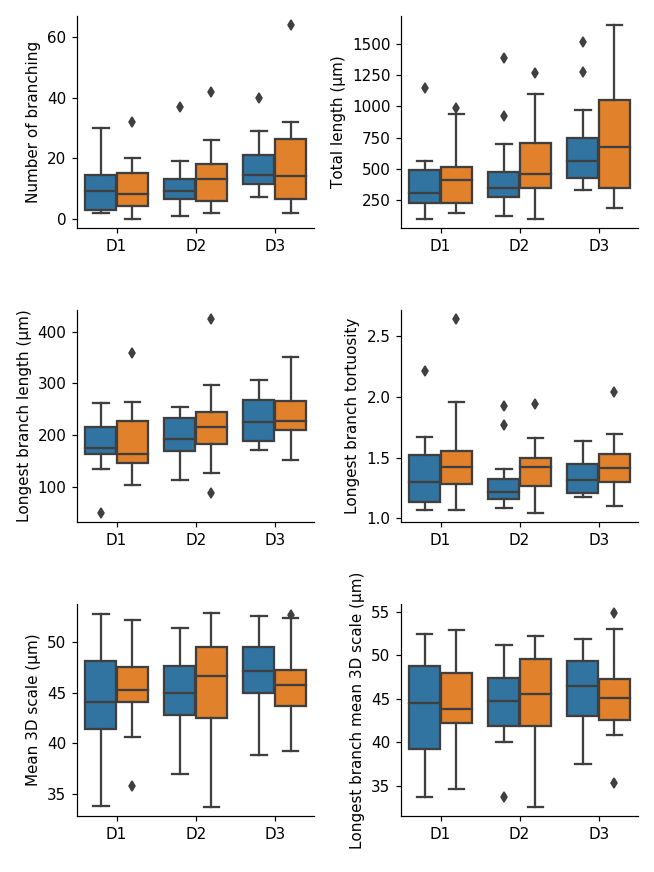

In [33]:
fig = plt.figure(figsize=(6,8))

ax = fig.add_subplot(321)
sns.boxplot(x="Day",y="Number of branching",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("");

ax = fig.add_subplot(322)
sns.boxplot(x="Day",y="Length",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Total length (µm)");
ax.set_xlabel("");

ax = fig.add_subplot(324)
pl = sns.boxplot(x="Day",y="Longest branch tortuosity",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("");

ax = fig.add_subplot(323)
sns.boxplot(x="Day",y="Longest branch length",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Longest branch length (µm)");
ax.set_xlabel("");

ax = fig.add_subplot(325)
sns.boxplot(x="Day",y="Mean 3D scale",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Mean 3D scale (µm)");
ax.set_xlabel("");

ax = fig.add_subplot(326)
sns.boxplot(x="Day",y="Longest branch mean 3D scale",data=subdf,hue="Experiment");
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Longest branch mean 3D scale (µm)");
ax.set_xlabel("");

plt.tight_layout();

## Statistical tests

In [34]:
test_feature = "Mean 3D scale"

value, day, treatment = [], [], []
for iday in ["D1","D2","D3"]:
    tmpdf = subdf[subdf["Day"]==iday]
    value = value + tmpdf[test_feature].tolist()
    day = day + [iday for _ in range(len(tmpdf))]
    treatment = treatment + tmpdf["Experiment"].tolist()
ssubdf = pd.DataFrame({"day":day,"treatment":treatment,"value":value})

ssubdf["day-treatment"] = ssubdf["day"]+"-"+ssubdf["treatment"]

# ssubdf["value"] = np.log(ssubdf["value"])
# ssubdf["value"] = np.sqrt(ssubdf["value"])
# ssubdf["value"] = np.sqrt(max(ssubdf["value"]+1)-ssubdf["value"])

ssubdf.head()

day treatment      value day-treatment
0  D1   CONTROL  52.772764    D1-CONTROL
1  D1   CONTROL  49.365297    D1-CONTROL
2  D1   CONTROL  46.880845    D1-CONTROL
3  D1   CONTROL  38.456110    D1-CONTROL
4  D1   CONTROL  44.043622    D1-CONTROL

### Ttest with holm-sidak

In [35]:
pval_lst = []
for iday in ["D1","D2","D3"]:
    var1 = ssubdf[(ssubdf["day"]==iday)&(ssubdf["treatment"]=="CONTROL")]["value"]
    var2 = ssubdf[(ssubdf["day"]==iday)&(ssubdf["treatment"]=="DSCAM")]["value"]
    _, pval = ttest_ind(var1,var2,equal_var=False)
    pval_lst.append(pval)
_, pval_lst_corr, _, _ = multipletests(pval_lst,method="holm-sidak")

print("p values:",pval_lst)
print("p values corrected:",pval_lst_corr)

p values: [0.5062198415978494, 0.5879325333893146, 0.5570294292102954]
p values corrected: [0.87960709 0.87960709 0.87960709]
